In [1]:
# === Cell 1: Mount Google Drive and import libraries ===

from google.colab import drive
drive.mount('/content/drive')

import os
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid", font_scale=1.2)

base_dir = "/content/drive/MyDrive/COGS118A_Final_Project"
data_dir = os.path.join(base_dir, "Data")
results_dir = os.path.join(base_dir, "Results")
os.makedirs(results_dir, exist_ok=True)

print("Data directory:", data_dir)
print("Results directory:", results_dir)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Data directory: /content/drive/MyDrive/COGS118A_Final_Project/Data
Results directory: /content/drive/MyDrive/COGS118A_Final_Project/Results


In [2]:
# === Cell 2: Load Parkinsons dataset using its own header ===
# Make sure parkinsons.data is in your Data folder.

parkinsons_path = os.path.join(data_dir, "parkinsons.data")

# Let pandas use the first row as the header (this matches the UCI file)
df_pd = pd.read_csv(parkinsons_path)

print("Shape of Parkinsons dataset:", df_pd.shape)
print("\nColumns:")
print(df_pd.columns.tolist())

print("\nFirst 5 rows:")
display(df_pd.head())

Shape of Parkinsons dataset: (195, 24)

Columns:
['name', 'MDVP:Fo(Hz)', 'MDVP:Fhi(Hz)', 'MDVP:Flo(Hz)', 'MDVP:Jitter(%)', 'MDVP:Jitter(Abs)', 'MDVP:RAP', 'MDVP:PPQ', 'Jitter:DDP', 'MDVP:Shimmer', 'MDVP:Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:APQ5', 'MDVP:APQ', 'Shimmer:DDA', 'NHR', 'HNR', 'status', 'RPDE', 'DFA', 'spread1', 'spread2', 'D2', 'PPE']

First 5 rows:


,name,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,...,Shimmer:DDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
0,phon_R01_S01_1,119.992,157.302,74.997,0.00784,0.00007,0.00370,0.00554,0.01109,0.04374,...,0.06545,0.02211,21.033,1,0.414783,0.815285,-4.813031,0.266482,2.301442,0.284654
1,phon_R01_S01_2,122.400,148.650,113.819,0.00968,0.00008,0.00465,0.00696,0.01394,0.06134,...,0.09403,0.01929,19.085,1,0.458359,0.819521,-4.075192,0.335590,2.486855,0.368674
2,phon_R01_S01_3,116.682,131.111,111.555,0.01050,0.00009,0.00544,0.00781,0.01633,0.05233,...,0.08270,0.01309,20.651,1,0.429895,0.825288,-4.443179,0.311173,2.342259,0.332634
3,phon_R01_S01_4,116.676,137.871,111.366,0.00997,0.00009,0.00502,0.00698,0.01505,0.05492,...,0.08771,0.01353,20.644,1,0.434969,0.819235,-4.117501,0.334147,2.405554,0.368975
4,phon_R01_S01_5,116.014,141.781,110.655,0.01284,0.00011,0.00655,0.00908,0.01966,0.06425,...,0.10470,0.01767,19.649,1,0.417356,0.823484,-3.747787,0.234513,2.332180,0.410335


In [3]:
# === Cell 3: Prepare feature matrix X_pd and label vector y_pd ===

# Drop the non-numeric 'name' column and keep all other numeric features
X_pd = df_pd.drop(columns=["name", "status"]).astype(float)

# 'status' is the binary label: 1 = Parkinson's, 0 = healthy
y_pd = df_pd["status"].astype(int)

print("X_pd shape:", X_pd.shape)
print("y_pd shape:", y_pd.shape)

print("\nClass distribution in y_pd:")
print(y_pd.value_counts())

X_pd shape: (195, 22)
y_pd shape: (195,)

Class distribution in y_pd:
status
1    147
0     48
Name: count, dtype: int64


In [4]:
# === Cell 4: Define helper to run 4 classifiers with GridSearchCV ===

def run_all_models_with_gridsearch(
    X_train, y_train, X_test, y_test,
    dataset_name="PD_Classification",
    train_size=0.8,
    trial=0
):
    """
    Runs Logistic Regression, SVM (RBF), Random Forest, and MLP
    with GridSearchCV on the given train/test split.

    Returns a DataFrame with one row per model, including:
    - dataset name
    - train_size
    - trial index
    - model name
    - best hyperparameters
    - CV accuracy
    - train accuracy
    - test accuracy
    """

    models_and_parameters = {
        "LogisticRegression": (
            Pipeline([
                ('scaler', StandardScaler()),
                ('clf', LogisticRegression(max_iter=1000))
            ]),
            {
                'clf__C': [0.01, 0.1, 1, 10, 100]
            }
        ),
        "SVM_RBF": (
            Pipeline([
                ('scaler', StandardScaler()),
                ('clf', SVC(kernel='rbf', random_state=0))
            ]),
            {
                'clf__C': [0.1, 1, 10, 100],
                'clf__gamma': ['scale', 0.01, 0.1, 1]
            }
        ),
        "RandomForest": (
            Pipeline([
                ('clf', RandomForestClassifier(random_state=0))
            ]),
            {
                'clf__n_estimators': [100, 300],
                'clf__max_depth': [None, 10, 20],
                'clf__min_samples_leaf': [1, 5]
            }
        ),
        "MLP": (
            Pipeline([
                ('scaler', StandardScaler()),
                ('clf', MLPClassifier(
                    max_iter=1000,
                    early_stopping=True,
                    n_iter_no_change=10,
                    random_state=0
                ))
            ]),
            {
                'clf__hidden_layer_sizes': [(50,), (100,), (50, 50)],
                'clf__alpha': [0.0001, 0.001],
                'clf__learning_rate_init': [0.001, 0.01]
            }
        )
    }

    results = []

    for name, (pipe, param_grid) in models_and_parameters.items():
        print(f"\n=== {dataset_name} | {name} | train_size={train_size}, trial={trial} ===")

        grid = GridSearchCV(
            estimator=pipe,
            param_grid=param_grid,
            scoring='accuracy',
            cv=5,
            n_jobs=-1,
            verbose=0
        )

        grid.fit(X_train, y_train)

        best_model = grid.best_estimator_
        best_params = grid.best_params_
        best_cv_score = grid.best_score_

        y_train_pred = best_model.predict(X_train)
        y_test_pred = best_model.predict(X_test)

        train_acc = accuracy_score(y_train, y_train_pred)
        test_acc = accuracy_score(y_test, y_test_pred)

        print("  Best params:", best_params)
        print(f"  CV accuracy:   {best_cv_score:.3f}")
        print(f"  Train accuracy:{train_acc:.3f}")
        print(f"  Test accuracy: {test_acc:.3f}")

        results.append({
            "dataset": dataset_name,
            "train_size": train_size,
            "trial": trial,
            "model": name,
            "best_params": best_params,
            "cv_accuracy": best_cv_score,
            "train_accuracy": train_acc,
            "test_accuracy": test_acc
        })

    return pd.DataFrame(results)

In [5]:
# === Cell 5: Run Parkinsons experiments (train_sizes x trials) ===

train_sizes = [0.2, 0.5, 0.8]
trials = [0, 1, 2]  # three different random seeds

pd_results_all = []

for ts in train_sizes:
    for t in trials:
        print(f"\n######## Parkinsons: train_size={ts}, trial={t} ########")

        X_train, X_test, y_train, y_test = train_test_split(
            X_pd,
            y_pd,
            train_size=ts,
            random_state=t,
            shuffle=True
            # no stratify here
        )

        df_res = run_all_models_with_gridsearch(
            X_train, y_train, X_test, y_test,
            dataset_name="Parkinsons",
            train_size=ts,
            trial=t
        )

        pd_results_all.append(df_res)

pd_results = pd.concat(pd_results_all, ignore_index=True)

print("\n=== First few rows of pd_results ===")
display(pd_results.head())


######## Parkinsons: train_size=0.2, trial=0 ########

=== Parkinsons | LogisticRegression | train_size=0.2, trial=0 ===
  Best params: {'clf__C': 0.1}
  CV accuracy:   0.768
  Train accuracy:0.821
  Test accuracy: 0.846

=== Parkinsons | SVM_RBF | train_size=0.2, trial=0 ===
  Best params: {'clf__C': 10, 'clf__gamma': 0.1}
  CV accuracy:   0.821
  Train accuracy:1.000
  Test accuracy: 0.795

=== Parkinsons | RandomForest | train_size=0.2, trial=0 ===
  Best params: {'clf__max_depth': None, 'clf__min_samples_leaf': 5, 'clf__n_estimators': 100}
  CV accuracy:   0.771
  Train accuracy:0.872
  Test accuracy: 0.788

=== Parkinsons | MLP | train_size=0.2, trial=0 ===
  Best params: {'clf__alpha': 0.0001, 'clf__hidden_layer_sizes': (50,), 'clf__learning_rate_init': 0.01}
  CV accuracy:   0.739
  Train accuracy:0.744
  Test accuracy: 0.724

######## Parkinsons: train_size=0.2, trial=1 ########

=== Parkinsons | LogisticRegression | train_size=0.2, trial=1 ===
  Best params: {'clf__C': 0.1}
 

,dataset,train_size,trial,model,best_params,cv_accuracy,train_accuracy,test_accuracy
0,Parkinsons,0.2,0,LogisticRegression,{'clf__C': 0.1},0.767857,0.820513,0.846154
1,Parkinsons,0.2,0,SVM_RBF,"{'clf__C': 10, 'clf__gamma': 0.1}",0.821429,1.000000,0.794872
2,Parkinsons,0.2,0,RandomForest,"{'clf__max_depth': None, 'clf__min_samples_lea...",0.771429,0.871795,0.788462
3,Parkinsons,0.2,0,MLP,"{'clf__alpha': 0.0001, 'clf__hidden_layer_size...",0.739286,0.743590,0.724359
4,Parkinsons,0.2,1,LogisticRegression,{'clf__C': 0.1},0.921429,0.923077,0.839744


In [6]:
# === Cell 6: Summarize PD Classification results (mean over 3 trials) ===

pd_summary = (
    pd_results
    .groupby(["model", "train_size"])
    .agg(
        mean_test_acc=("test_accuracy", "mean"),
        std_test_acc=("test_accuracy", "std"),
        mean_train_acc=("train_accuracy", "mean"),
        mean_cv_acc=("cv_accuracy", "mean")
    )
    .reset_index()
)

print("=== PD Classification summary ===")
display(pd_summary)

=== PD Classification summary ===


,model,train_size,mean_test_acc,std_test_acc,mean_train_acc,mean_cv_acc
0,LogisticRegression,0.2,0.852564,0.016960,0.871795,0.845238
1,LogisticRegression,0.5,0.836735,0.030612,0.917526,0.879825
2,LogisticRegression,0.8,0.846154,0.067840,0.882479,0.852755
3,MLP,0.2,0.790598,0.064209,0.837607,0.777381
4,MLP,0.5,0.799320,0.032802,0.859107,0.841930
5,MLP,0.8,0.863248,0.014804,0.871795,0.850806
6,RandomForest,0.2,0.822650,0.030294,0.957265,0.836905
7,RandomForest,0.5,0.836735,0.035348,0.979381,0.896491
8,RandomForest,0.8,0.888889,0.064528,1.000000,0.882594
9,SVM_RBF,0.2,0.835470,0.036450,0.948718,0.863095


In [7]:
# === Cell 7: Save PD Classification results to CSV ===

detailed_path = os.path.join(results_dir, "pdcls_results_detailed.csv")
summary_path  = os.path.join(results_dir, "pdcls_results_summary.csv")

pd_results.to_csv(detailed_path, index=False)
pd_summary.to_csv(summary_path, index=False)

print("Saved:")
print(" -", detailed_path)
print(" -", summary_path)

Saved:
 - /content/drive/MyDrive/COGS118A_Final_Project/Results/pdcls_results_detailed.csv
 - /content/drive/MyDrive/COGS118A_Final_Project/Results/pdcls_results_summary.csv


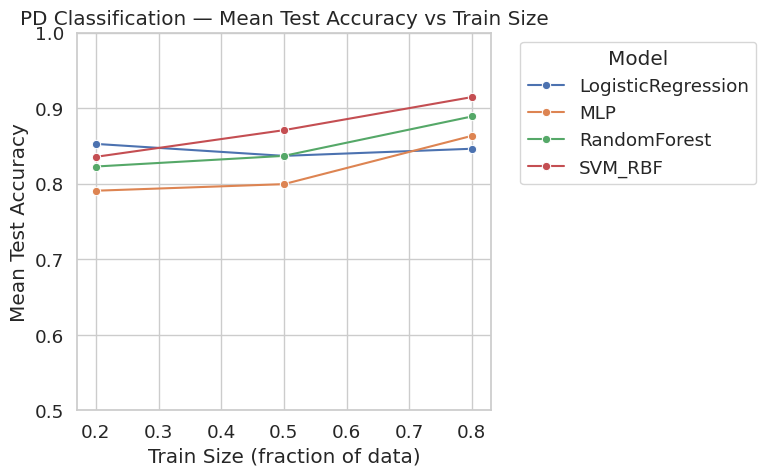

In [8]:
# === Cell 8 (optional): PD Classification — Test Accuracy vs Train Size ===

plt.figure(figsize=(8, 5))
sns.lineplot(
    data=pd_summary,
    x="train_size",
    y="mean_test_acc",
    hue="model",
    marker="o"
)
plt.title("PD Classification — Mean Test Accuracy vs Train Size")
plt.xlabel("Train Size (fraction of data)")
plt.ylabel("Mean Test Accuracy")
plt.ylim(0.5, 1.0)
plt.legend(title="Model", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/COGS118A_Final_Project/Plots/parkinsons_testacc_vs_trainsize.png", dpi=300, bbox_inches='tight')
plt.show()